In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import holoviews as hv
import hvplot.polars  # noqa
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_crosscorr_matrix,
    plot_averages_with_ci_plt,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [ ]:
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

df = df.rename({"rating": "pain_rating", "pupil": "pupil_diameter"})

In [5]:
signals = [
    "temperature",
    "pain_rating",
    "heart_rate",
    "pupil_diameter",
    "eda_tonic",
    "eda_phasic",
]


## Averaged trials over stimulus seeds with confidence intervals

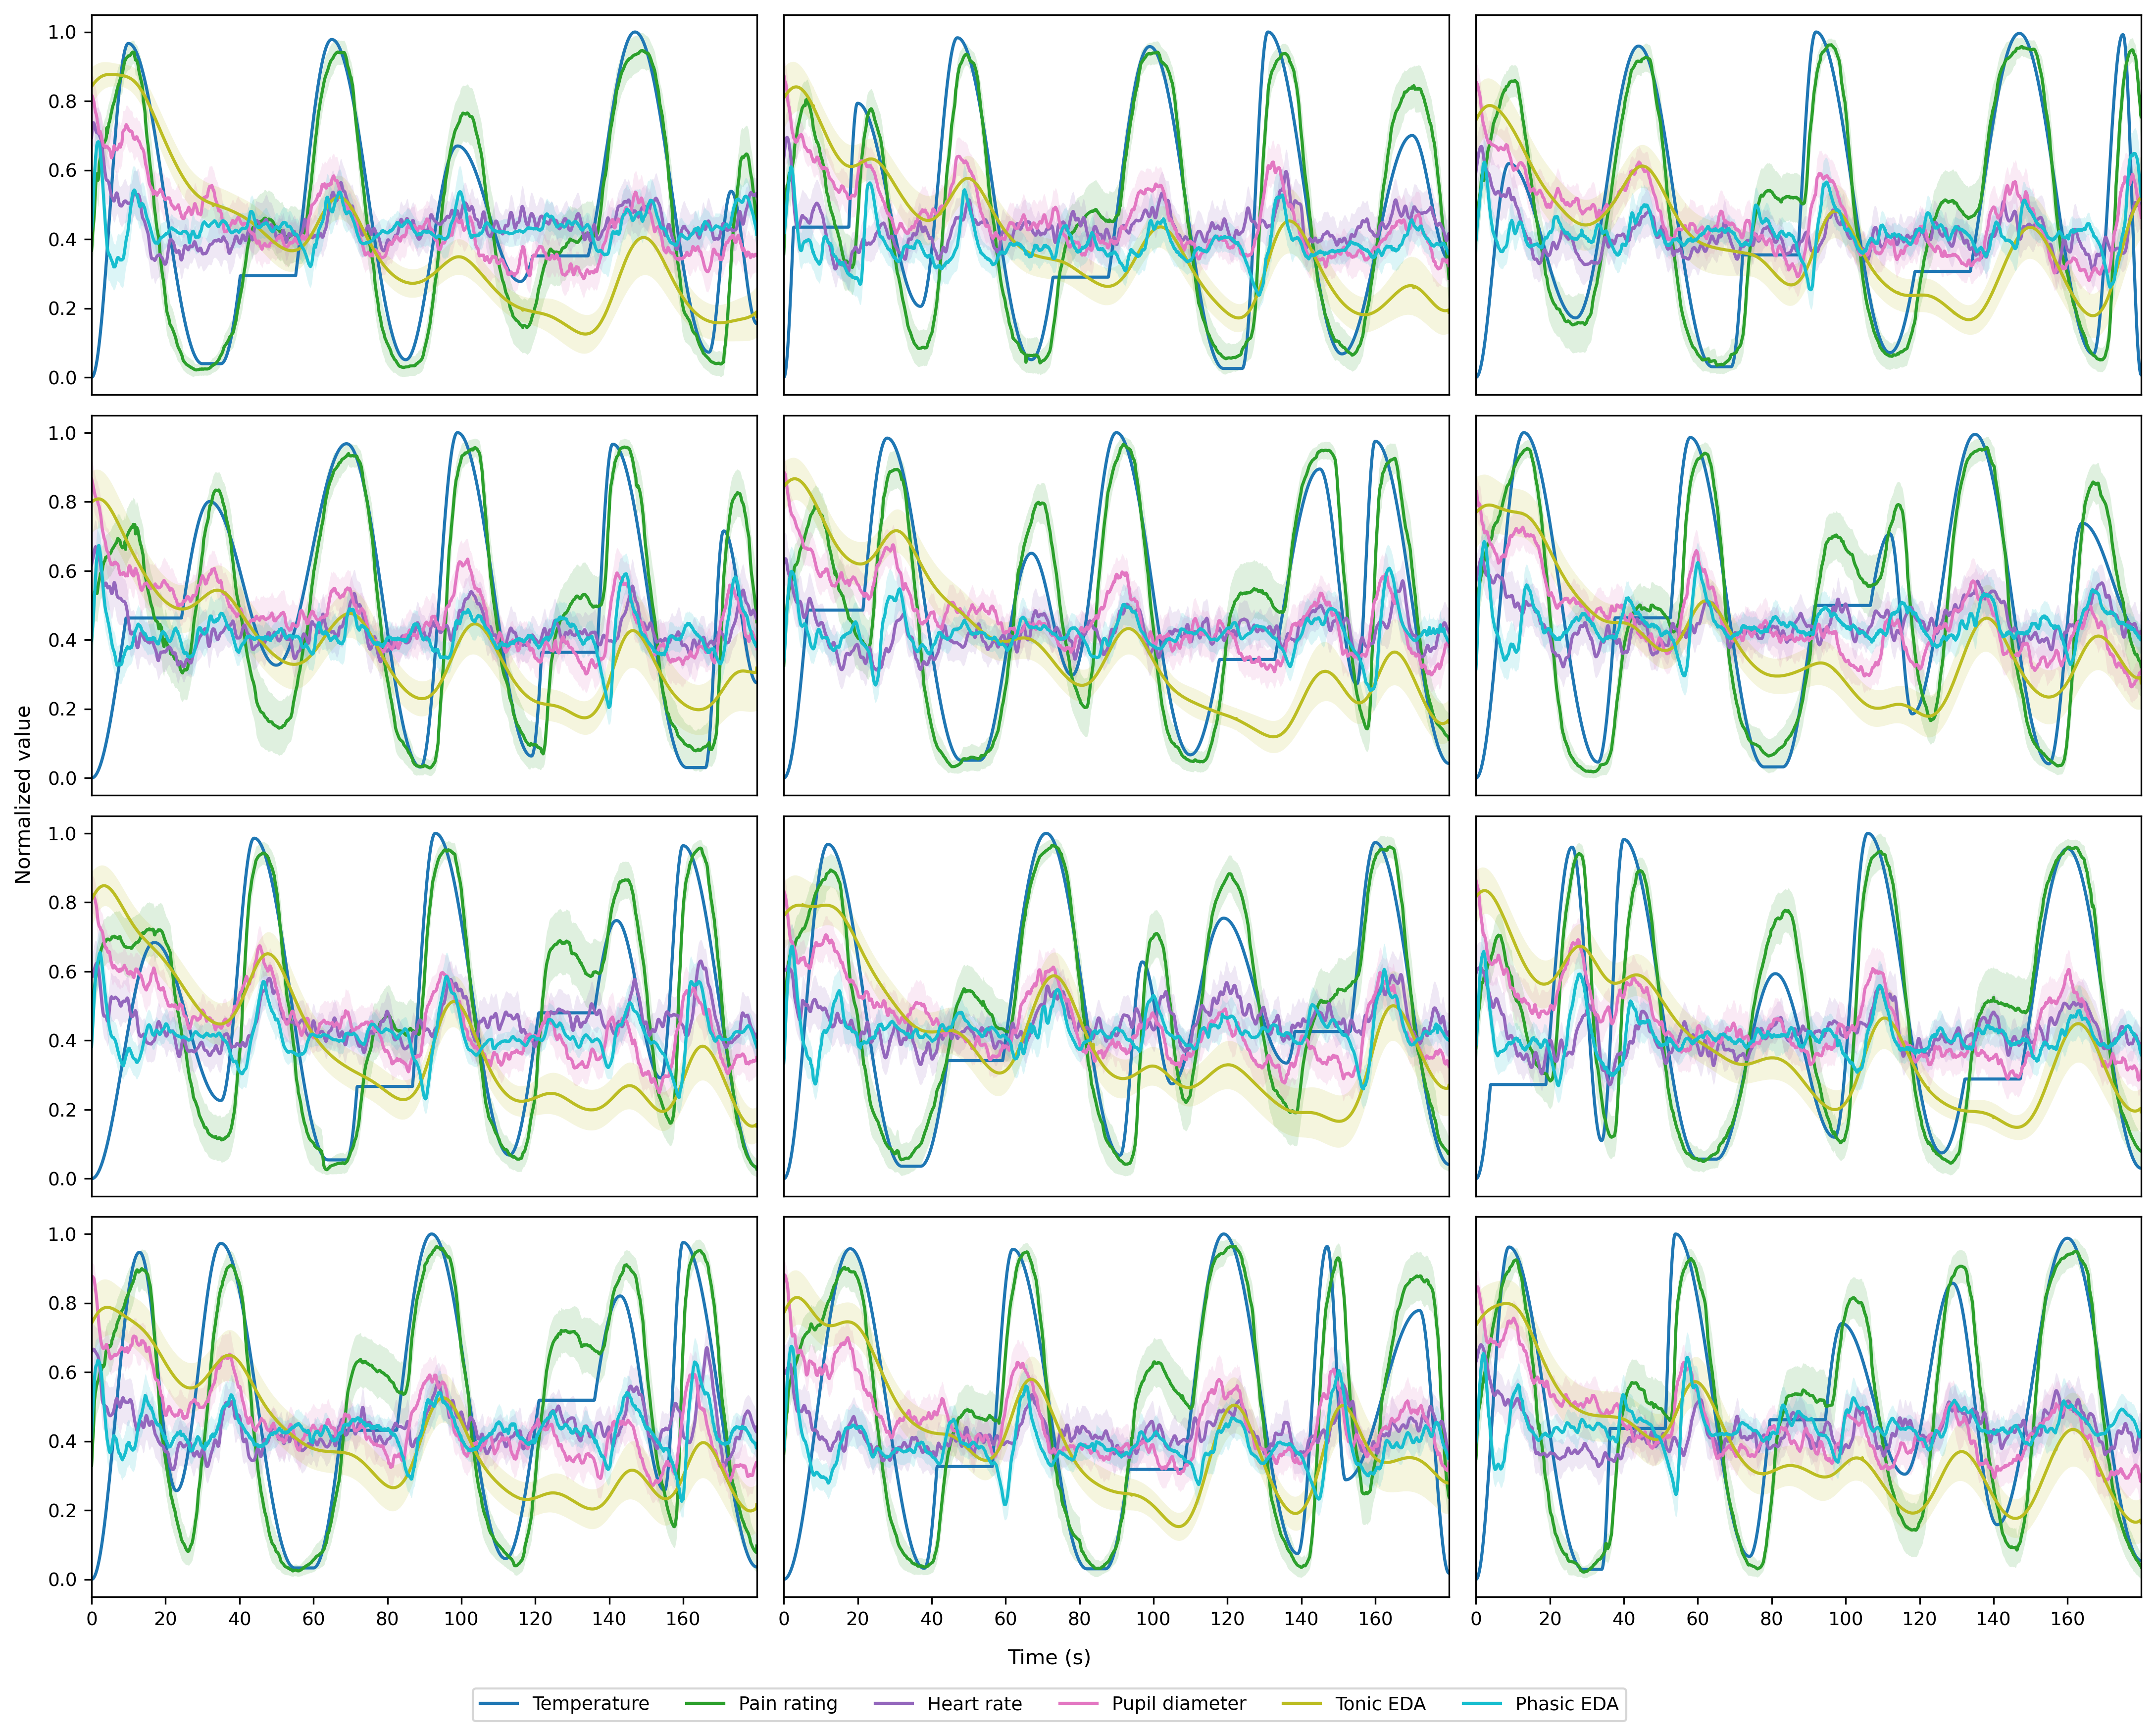

In [15]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plots = plot_averages_with_ci_plt(
    averges_with_ci,
    signals,
)

In [16]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

plots.savefig(FIGURE_DIR / "averages_over_stimulus_seeds.png")

In [8]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

In [9]:
averages

shape: (19_200, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ stimulus_ ┆ avg_tempe ┆ avg_pain_ ┆ avg_heart ┆ … ┆ std_eda_t ┆ std_eda_p ┆ sample_si ┆ time_bin │
│ seed      ┆ rature    ┆ rating    ┆ _rate     ┆   ┆ onic      ┆ hasic     ┆ ze        ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64      │
│ u16       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ u32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 133       ┆ 0.500538  ┆ 0.227467  ┆ 0.327791  ┆ … ┆ 0.173878  ┆ 0.122492  ┆ 37        ┆ 20.0     │
│ 133       ┆ 0.493263  ┆ 0.215004  ┆ 0.329378  ┆ … ┆ 0.174004  ┆ 0.123752  ┆ 37        ┆ 20.1     │
│ 133       ┆ 0.485975  ┆ 0.204909  ┆ 0.332351  ┆ … ┆ 0.174118  ┆ 0.122598  ┆ 37        ┆ 20.2     │
│ 133       ┆ 0.478646  ┆ 0.196032  ┆ 0.336022  ┆ … ┆ 0.174168  ┆ 0.121638  ┆ 37        ┆ 20.3     │
│ 133       ┆ 0.471355  ┆ 0.188876  ┆ 0.341572  ┆ … ┆ 0.174326  ┆ 0.121965  ┆ 37        ┆ 20.4     │
│ 133       ┆ 0.464048  ┆ 0.1846    ┆ 0.348605  ┆ … ┆ 0.17447   ┆ 0.122033  ┆ 37        ┆ 20.5     │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 952       ┆ 0.055794  ┆ 0.045383  ┆ 0.420739  ┆ … ┆ 0.206152  ┆ 0.145278  ┆ 40        ┆ 179.4    │
│ 952       ┆ 0.055265  ┆ 0.042738  ┆ 0.421924  ┆ … ┆ 0.206187  ┆ 0.142599  ┆ 40        ┆ 179.5    │
│ 952       ┆ 0.05485   ┆ 0.041118  ┆ 0.422477  ┆ … ┆ 0.206312  ┆ 0.138084  ┆ 40        ┆ 179.6    │
│ 952       ┆ 0.054551  ┆ 0.040157  ┆ 0.422001  ┆ … ┆ 0.206481  ┆ 0.134005  ┆ 40        ┆ 179.7    │
│ 952       ┆ 0.05437   ┆ 0.039761  ┆ 0.421153  ┆ … ┆ 0.206585  ┆ 0.135591  ┆ 40        ┆ 179.8    │
│ 952       ┆ 0.054299  ┆ 0.036165  ┆ 0.412395  ┆ … ┆ 0.197338  ┆ 0.147393  ┆ 46        ┆ 179.9    │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

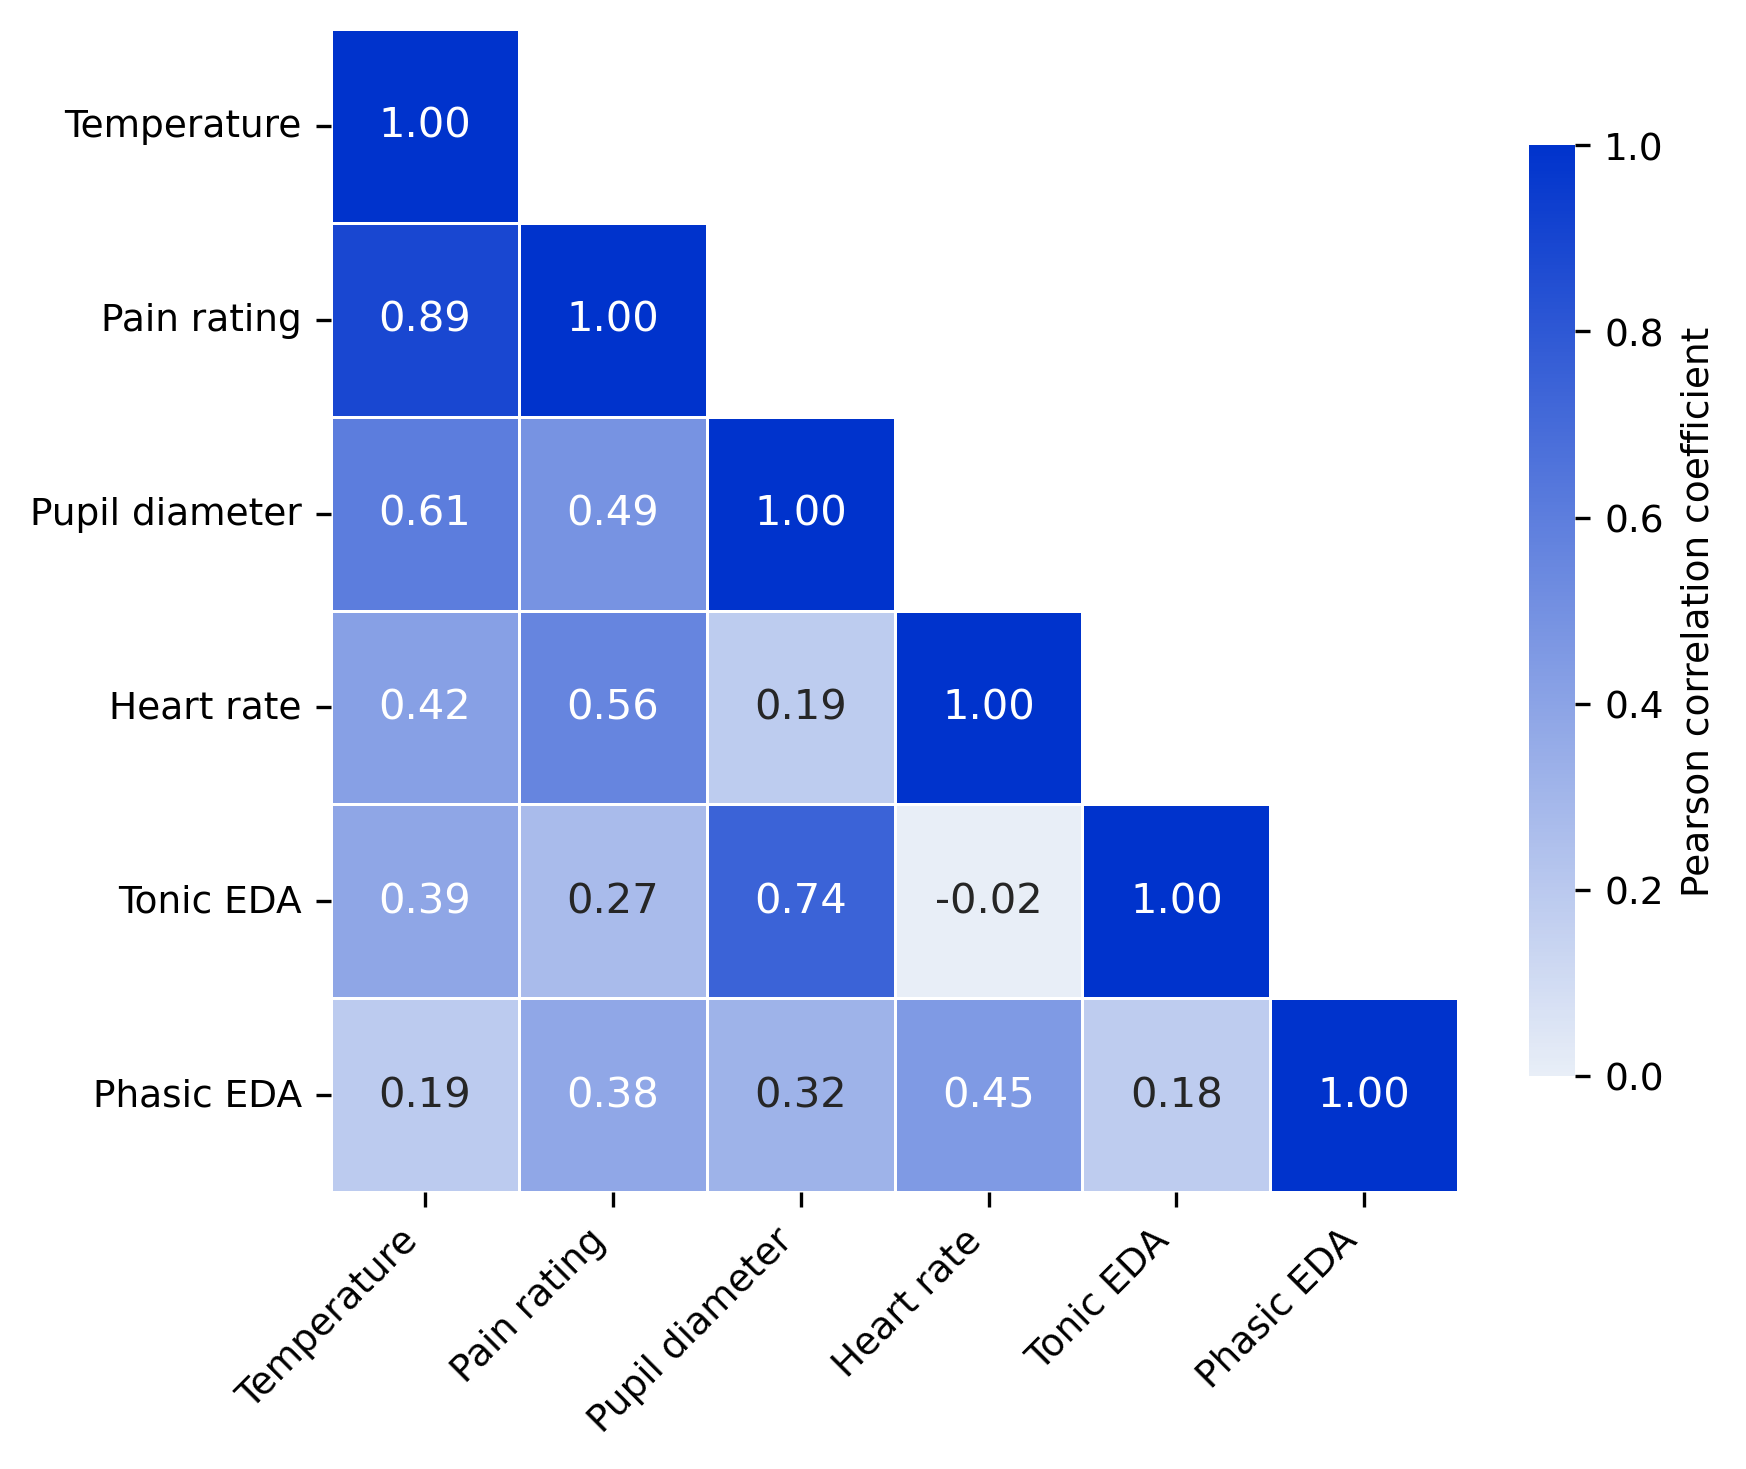

In [10]:
# without first 20 seconds
correlation_heatmap = plot_correlation_heatmap(averages)

In [11]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)

In [17]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_diameter", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)


(np.float64(0.38), np.float64(0.05))

## Cross correlation lags of grand means

In [12]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="temperature",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ temperature      ┆ pupil_diameter ┆ -0.066667 ┆ 0.221108 │
│ temperature      ┆ eda_tonic      ┆ -0.95     ┆ 0.589491 │
│ temperature      ┆ pain_rating    ┆ -1.008333 ┆ 0.335307 │
│ temperature      ┆ heart_rate     ┆ -1.758333 ┆ 1.362264 │
│ temperature      ┆ eda_phasic     ┆ -2.45     ┆ 0.886472 │
└──────────────────┴────────────────┴───────────┴──────────┘

In [13]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="pain_rating",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_rating_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ pain_rating      ┆ temperature    ┆ 1.008333  ┆ 0.335307 │
│ pain_rating      ┆ pupil_diameter ┆ 0.608333  ┆ 0.714677 │
│ pain_rating      ┆ eda_tonic      ┆ -0.1      ┆ 0.177951 │
│ pain_rating      ┆ heart_rate     ┆ -0.341667 ┆ 0.526717 │
│ pain_rating      ┆ eda_phasic     ┆ -0.516667 ┆ 0.468745 │
└──────────────────┴────────────────┴───────────┴──────────┘

In [14]:
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)